In [1]:
###################################################
## Post Process the primary care research corpus results --- structure author lists into edge list, network adjacency matrix
##
## Author: Chris Meaney
## Date: January 2023
###################################################

In [2]:
############
## Dependencies
############

## For network analysis
library(igraph)


Attaching package: 'igraph'


The following objects are masked from 'package:stats':

    decompose, spectrum


The following object is masked from 'package:base':

    union




In [3]:
##############
## Filepaths to import data from disk, and export data to disk
##############

## Import core scopus dataframe
fpath_scopus <- "D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\CoreData_Mined\\Core_Scopus_Dataset_Sm.csv"

## Import eid for edge list construction
fpath_eid1 <- "D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\CoreData_Mined\\Scopus_CoAuthNetwork_EID1.csv"
fpath_eid2 <- "D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\CoreData_Mined\\Scopus_CoAuthNetwork_EID2.csv"

## Import author affiliation data
affils_eid_fpath1 <- "D://CopyZ_30Nov2020//DFCM_Docs//DFCM_Researchers//PeterSelby//MineScopus_DFCM_National_International_PrimaryCareResearchPrograms//CoreData_Mined//Scopus_CoAuthAffiliationNetwork_EID1.csv"
affils_eid_fpath2 <- "D://CopyZ_30Nov2020//DFCM_Docs//DFCM_Researchers//PeterSelby//MineScopus_DFCM_National_International_PrimaryCareResearchPrograms//CoreData_Mined//Scopus_CoAuthAffiliationNetwork_EID2.csv"

## Import IDs 
ids_fpath <- "D://CopyZ_30Nov2020//DFCM_Docs//DFCM_Researchers//PeterSelby//MineScopus_DFCM_National_International_PrimaryCareResearchPrograms//ZZZ_ScopusIDs//ZZZ_ScopusIDs//Final_Combined_ScopusIdsFile_JayaSelena.csv"

In [4]:
##################################
## Import Scopus dataset
##################################
scopus_df <- read.csv(file=fpath_scopus, header=TRUE, sep=",", stringsAsFactors=FALSE)
str(scopus_df)

'data.frame':	18874 obs. of  25 variables:
 $ au_id         : num  1e+10 1e+10 1e+10 1e+10 1e+10 ...
 $ prism_url     : chr  "https://api.elsevier.com/content/abstract/scopus_id/85140976962" "https://api.elsevier.com/content/abstract/scopus_id/85121747496" "https://api.elsevier.com/content/abstract/scopus_id/85112107056" "https://api.elsevier.com/content/abstract/scopus_id/85118672412" ...
 $ eid           : chr  "2-s2.0-85140976962" "2-s2.0-85121747496" "2-s2.0-85112107056" "2-s2.0-85118672412" ...
 $ doi           : chr  "10.1016/j.socscimed.2022.115463" "10.1111/add.15760" "10.1016/j.socscimed.2021.114262" "10.3399/BJGP.2021.0195" ...
 $ issn          : chr  "02779536" "09652140" "02779536" "09601643" ...
 $ eissn         : chr  "18735347" "13600443" "18735347" "14785242" ...
 $ pub_title     : chr  "Brief opportunistic interventions by general practitioners to promote smoking cessation: A conversation analytic study" "The old and familiar meets the new and unknown: patient and clin

In [5]:
## Only keep publications from certain years --- 2000:2021
table(scopus_df$pub_year)


2017 2018 2019 2020 2021 2022 
2591 2811 2823 3075 3617 3957 

In [6]:
## Map institution to region
scopus_df$au_institution_country <- with(scopus_df, 
                                                       ifelse(au_institution %in% c("Toronto","UBC","McGill","Laval","Ottawa"), "Canada",
                                                       ifelse(au_institution %in% c("Dartmouth","Michigan","Duke","OHSU","UCSF","Harvard"), "USA",
                                                       ifelse(au_institution %in% c("Oxford", "Cambridge","UCL"), "UK", "Other"))))

table(scopus_df$au_institution, scopus_df$au_institution_country)

           
            Canada Other   UK  USA
  Cambridge      0     0  560    0
  Dartmouth      0     0    0 1173
  Duke           0     0    0  380
  Harvard        0     0    0  485
  HKU            0   648    0    0
  Laval        785     0    0    0
  McGill      1025     0    0    0
  Michigan       0     0    0  793
  Monash         0   455    0    0
  OHSU           0     0    0  752
  Ottawa       774     0    0    0
  Oxford         0     0 5443    0
  Toronto     2484     0    0    0
  UBC          920     0    0    0
  UCL            0     0 1526    0
  UCSF           0     0    0  421
  UNSW           0   250    0    0

In [7]:
## How many unique institutions
length(unique(scopus_df$au_institution))

[1] 17

In [8]:
## How many unique authors
length(unique(scopus_df$au_name))

[1] 591

In [9]:
## Get original set of authors (N=591) no duplicates
scopus_df_uniq <- scopus_df[!(duplicated(scopus_df$au_name)), c("au_id","au_name","au_institution")]
dim(scopus_df_uniq)

[1] 591   3

In [10]:
head(scopus_df_uniq)

,au_id,au_name,au_institution
,<dbl>,<chr>,<chr>
1,10041373600,RebeccaBarnes,Oxford
34,10240446500,ChristineTCigolle,Michigan
49,12791296200,ClaireKendall,Ottawa
122,12804958400,MinaRuthSilberberg,Duke
137,14421205500,BertrandLebouche,McGill
217,14826143300,ClaudeTopping,Laval


In [11]:
#################################
##
## Import EID authors/ids files
##
#################################
eid_results1 <- read.csv(file=fpath_eid1, header=TRUE, sep=",")
eid_results2 <- read.csv(file=fpath_eid2, header=TRUE, sep=",")

eid_results <- rbind(eid_results1, eid_results2)

str(eid_results)

'data.frame':	150906 obs. of  4 variables:
 $ eid   : chr  "2-s2.0-85140976962" "2-s2.0-85140976962" "2-s2.0-85140976962" "2-s2.0-85140976962" ...
 $ auths : chr  "Wheat H." "Barnes R.K." "Aveyard P." "Stevenson F." ...
 $ ids   : num  5.64e+10 1.00e+10 5.51e+10 7.10e+09 3.51e+10 ...
 $ doc_id: int  1 1 1 1 1 2 2 2 2 2 ...


In [12]:
##
## Descriptive stats
##
list(
    dim(eid_results),
    length(unique(eid_results$eid)),
    length(unique(eid_results$doc_id)),
    length(unique(eid_results$ids))
)

[[1]]
[1] 150906      4

[[2]]
[1] 13098

[[3]]
[1] 13098

[[4]]
[1] 66686

In [13]:
#head(eid_results)

In [14]:
## Number unique authors (including the N=591 ppl in the original Scopus query)
list(
    length(unique(eid_results$ids)),
    length(unique(eid_results$auths))
    )

[[1]]
[1] 66686

[[2]]
[1] 62515

In [15]:
## Number unique authors --- after subtracting off the original N=591 included in the Scopus query
length(unique(eid_results$ids)) - length(unique(scopus_df$au_name))

[1] 66095

In [16]:
##
## Normalize author names lists
## 
## WARNING --- this is a bit HACKY; and we expect that it will resolve some problems while creating other new problems
## For example, for common/generic Asian family names restricting to LastName+FirstInitial may not be enough granularity to uniquely specify authors
##

## See weird case for example
# eid_results[grepl(x=eid_results$auths, pattern="Upshur"), ]
eid_results$auths_norm <- sapply(strsplit(x=eid_results$auths, split="\\."), function(x) x[[1]])
# eid_results[grepl(x=eid_results$auths_norm, pattern="Upshur"), ]

list(
    length(unique(eid_results$auths)),
    length(unique(eid_results$auths_norm)),
    length(unique(eid_results$ids))
)

[[1]]
[1] 62515

[[2]]
[1] 55335

[[3]]
[1] 66686

In [17]:
##
##
## Note...you will get slightly/subtly different answers depending on your definition of an author/person
## For example, is an author/person defined by 1) Scopus ID, 2) author name, 3) normalized author name, 4) some other identifier, etc.
## Here we use Scopus ID because we think it is less biased than author name --- but we acknowledge it is NOT perfect
## For example, some unique authors/people may have multiple Scopus IDs (a multiplicity problem)...
##
##

In [18]:
##
## Split into separate eid files
##
eid_split <- split(eid_results, f=as.factor(eid_results$eid))
length(eid_split)

[1] 13098

In [19]:
## Get number of authors per publication (based on eid)
num_authors <- sapply(eid_split, nrow)

num_authors_df <- data.frame(table(num_authors))
prop_authors_df <- data.frame(prop.table(table(num_authors)))

authors_df <- cbind(num_authors_df, round(prop_authors_df[,2]*100, 2))
authors_df <- data.frame(apply(authors_df, 2, as.numeric))
names(authors_df) <- c("num_authors", "freq", "prop")
authors_df

num_authors,freq,prop
<dbl>,<dbl>,<dbl>
1,1184,9.04
2,416,3.18
3,731,5.58
4,1178,8.99
5,1347,10.28
6,1367,10.44
7,1217,9.29
8,995,7.60
9,817,6.24


In [20]:
## Check on author freq counts
list(
    dim(eid_results),
    sum(authors_df$num_authors * authors_df$freq)
)

[[1]]
[1] 150906      5

[[2]]
[1] 150906

In [21]:
## Quantiles on number of authors
data.frame(num_authors=quantile(num_authors, probs=c(0, 0.25, 0.50, 0.75, 1.0)))

,num_authors
,<dbl>
0%,1
25%,4
50%,7
75%,10
100%,3391


In [22]:
## Number of collaborators - minus the number of original authors in the search/query
list(
    length(unique(eid_results$ids)),
    length(unique(eid_results$ids)) - length(unique(scopus_df$au_name))
)

[[1]]
[1] 66686

[[2]]
[1] 66095

In [23]:
## Investigate weird cases with >1000 authors on publication 
## We have seen some large international collaborations of this nature
## However, for assessing collaboration, we feel it is best to drop these edge cases, as to not distort traditional small/medium team collaboration

# big_collabs <- eid_split[sapply(eid_split, nrow) > 1000]
# length(big_collabs)
# big_collabs[1]

## Note: these seem like legit, albeit, really big team science projects

In [24]:
##
## For now I will leave these in, since it makes counting collaborations more consistent
## However, I **think** these few very large collaborations may distort estimation of centrality measures
##
## That said, the removal of large collaborative projects is very subjective
## And further, the exact threshold for determination of what is big (>10, >25, >50, >100, etc.) is quite subjective
##

In [25]:
## Create flag and drop articles with very many authors (say num_authors>25)
num_authors_flag <- num_authors>25
table(num_authors_flag)

num_authors_flag
FALSE  TRUE 
12597   501 

In [26]:
eid_split <- eid_split[!num_authors_flag]
length(eid_split)

[1] 12597

In [27]:
##
## Get Author Pairs DF --- Note: this is based on unique Scopus ID (an assumption; noting we could use given name)
##
t0 <- Sys.time()

author_pairs_list <- lapply(eid_split, function(x) subset(expand.grid(x$ids, x$ids),Var1!=Var2))
el_auth <- do.call("rbind", author_pairs_list)
names(el_auth) <- c("Auth1","Auth2")
el_auth$Auth1 <- as.character(el_auth$Auth1)
el_auth$Auth2 <- as.character(el_auth$Auth2)

t1 <- Sys.time()
t1-t0

Time difference of 5.886382 secs

In [28]:
list(
    #str(el_auth),
    dim(el_auth),
    length(unique(c(el_auth$Auth1, el_auth$Auth2)))
)

[[1]]
[1] 898788      2

[[2]]
[1] 36176

In [29]:
## 
## Note: the dimension above are essentially the number of vertex-to-vertex ties/edges
## Note: we DOUBLE COUNT above; since we include both a->b and b->a type ties
## Note: we have EXCLUDED the a->a type ties/edges
## 
## Hence...the total number of ties is nrow(el_auth)/2
##

In [30]:
## Total number of unique ties/edges
nrow(el_auth)/2

[1] 449394

In [31]:
##
## Note: this number/estimate is IMO greatly inflated because of some outlying LARGE studies
##
## For example, our largest study contains 3300ish authors --- this study alone creates choose(3300,2) ties ~ 5M
##

In [32]:
head(el_auth)

,Auth1,Auth2
,<chr>,<chr>
2-s2.0-79960678065.2,6603627308,23498419200
2-s2.0-79960678065.3,7201918014,23498419200
2-s2.0-79960678065.4,7003757445,23498419200
2-s2.0-79960678065.5,8240813400,23498419200
2-s2.0-79960678065.6,23498419200,6603627308
2-s2.0-79960678065.8,7201918014,6603627308


In [33]:
###############################
##
## Grab all co-author pairs - for coauthorship network analysis
##
###############################

##
## Create network graph from directed citation edge-list
##

el_auth <- el_auth[!is.na(el_auth$Auth1), ]
el_auth <- el_auth[!is.na(el_auth$Auth2), ]
el_auth <- el_auth[el_auth$Auth1 != "", ]
el_auth <- el_auth[el_auth$Auth2 != "", ]
dim(el_auth)

[1] 898788      2

In [34]:
## Co-Authorship Network Graph
t0 <- Sys.time()
g_auth <- graph_from_edgelist(el=as.matrix(el_auth), directed=FALSE)
t1 <- Sys.time()
t1-t0

saveRDS(g_auth, file="D:\\CopyZ_30Nov2020\\DFCM_Docs\\DFCM_Researchers\\PeterSelby\\MineScopus_DFCM_National_International_PrimaryCareResearchPrograms\\Output_NetworkAnalysis\\Author_Network.RDS")
# g_auth <- readRDS(file="C:\\Users\\ChristopherMeaney\\Desktop\\FamMedTopicModel\\mine_dfcm_scopus\\Author_Network.RDS")

Time difference of 3.496851 secs

In [35]:
##
## Assign color attributes to graph
##

## Color for all persons not faculty/staff in one of our bottom-up sampled N=17 institutions
V(g_auth)$color <- "black"

## Rainbow colors for everyone else in one of the N=17 institutions
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Toronto", "au_id"])] <- rainbow(17)[1]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Ottawa", "au_id"])] <- rainbow(17)[2]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="McGill", "au_id"])] <- rainbow(17)[3]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Laval", "au_id"])] <- rainbow(17)[4]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="UBC", "au_id"])] <- rainbow(17)[5]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Harvard", "au_id"])] <- rainbow(17)[6]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Dartmouth", "au_id"])] <- rainbow(17)[7]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Duke", "au_id"])] <- rainbow(17)[8]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="UCSF", "au_id"])] <- rainbow(17)[9]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Michigan", "au_id"])] <- rainbow(17)[10]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="OHSU", "au_id"])] <- rainbow(17)[11]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Oxford", "au_id"])] <- rainbow(17)[12]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Cambridge", "au_id"])] <- rainbow(17)[13]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="UCL", "au_id"])] <- rainbow(17)[14]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="UNSW", "au_id"])] <- rainbow(17)[15]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="Monash", "au_id"])] <- rainbow(17)[16]
V(g_auth)$color[which(V(g_auth)$name %in% scopus_df_uniq[scopus_df_uniq$au_institution=="HKU", "au_id"])] <- rainbow(17)[17]

In [36]:
## Check how many people assigned to each color
col_freq_df <- data.frame(table(V(g_auth)$color))
names(col_freq_df) <- c("col", "col_freq")
col_freq_df

col,col_freq
<fct>,<int>
#001EFF,165
#0078FF,19
#00D2FF,28
#00FF1E,45
#00FF78,13
#00FFD2,12
#3C00FF,8
#3CFF00,22
#9600FF,51


In [37]:
## Check how many people assigned to each institution
au_freq_df <- data.frame(table(scopus_df_uniq$au_institution))
names(au_freq_df) <- c("inst", "au_freq")
au_freq_df

inst,au_freq
<fct>,<int>
Cambridge,8
Dartmouth,48
Duke,13
Harvard,22
HKU,11
Laval,30
McGill,31
Michigan,28
Monash,15


In [38]:
## Merge above data into data.frame created below
inst_names <- c("Toronto",
                "Ottawa",
               "McGill",
               "Laval",
               "UBC",
               "Harvard",
               "Dartmouth",
               "Duke",
               "UCSF",
               "Michigan",
               "OHSU",
               "Oxford",
               "Cambridge",
               "UCL",
               "UNSW",
               "Monash",
               "HKU")

pal <- data.frame(col=rainbow(17), inst=inst_names)

pal <- merge(x=pal, y=au_freq_df, by="inst", all=TRUE)
pal <- merge(x=pal, y=col_freq_df, by="col", all=TRUE)

## This shows that we lose a few people in the network graph --- since they must not be included in Scopus IDs
## This could be an issue of how they are assigned Scopus IDs??
pal

col,inst,au_freq,col_freq
<chr>,<chr>,<int>,<int>
#001EFF,Oxford,169,165
#0078FF,OHSU,19,19
#00D2FF,Michigan,28,28
#00FF1E,Dartmouth,48,45
#00FF78,Duke,13,13
#00FFD2,UCSF,12,12
#3C00FF,Cambridge,8,8
#3CFF00,Harvard,22,22
#9600FF,UCL,51,51


In [39]:
#############################################
##
## Try to plot the co-author graph
## https://kateto.net/wp-content/uploads/2016/01/NetSciX_2016_Workshop.pdf
##
#############################################

## Number of authors

list(
dim(el_auth),
length(unique(el_auth$Auth1)),
length(unique(el_auth$Auth2)),
length(unique(c(el_auth$Auth1, el_auth$Auth2)))
)

[[1]]
[1] 898788      2

[[2]]
[1] 36176

[[3]]
[1] 36176

[[4]]
[1] 36176

In [40]:
## Which names will be plotted on vertex

# threshold <- 750
# names(V(g_auth))[degree(g_auth)>threshold]

#l <- layout.lgl(g_auth,  
#       maxiter=150,
#       maxdelta=vcount(g_auth),
#       area=vcount(g_auth)^2,
#       coolexp=1.5
#       )

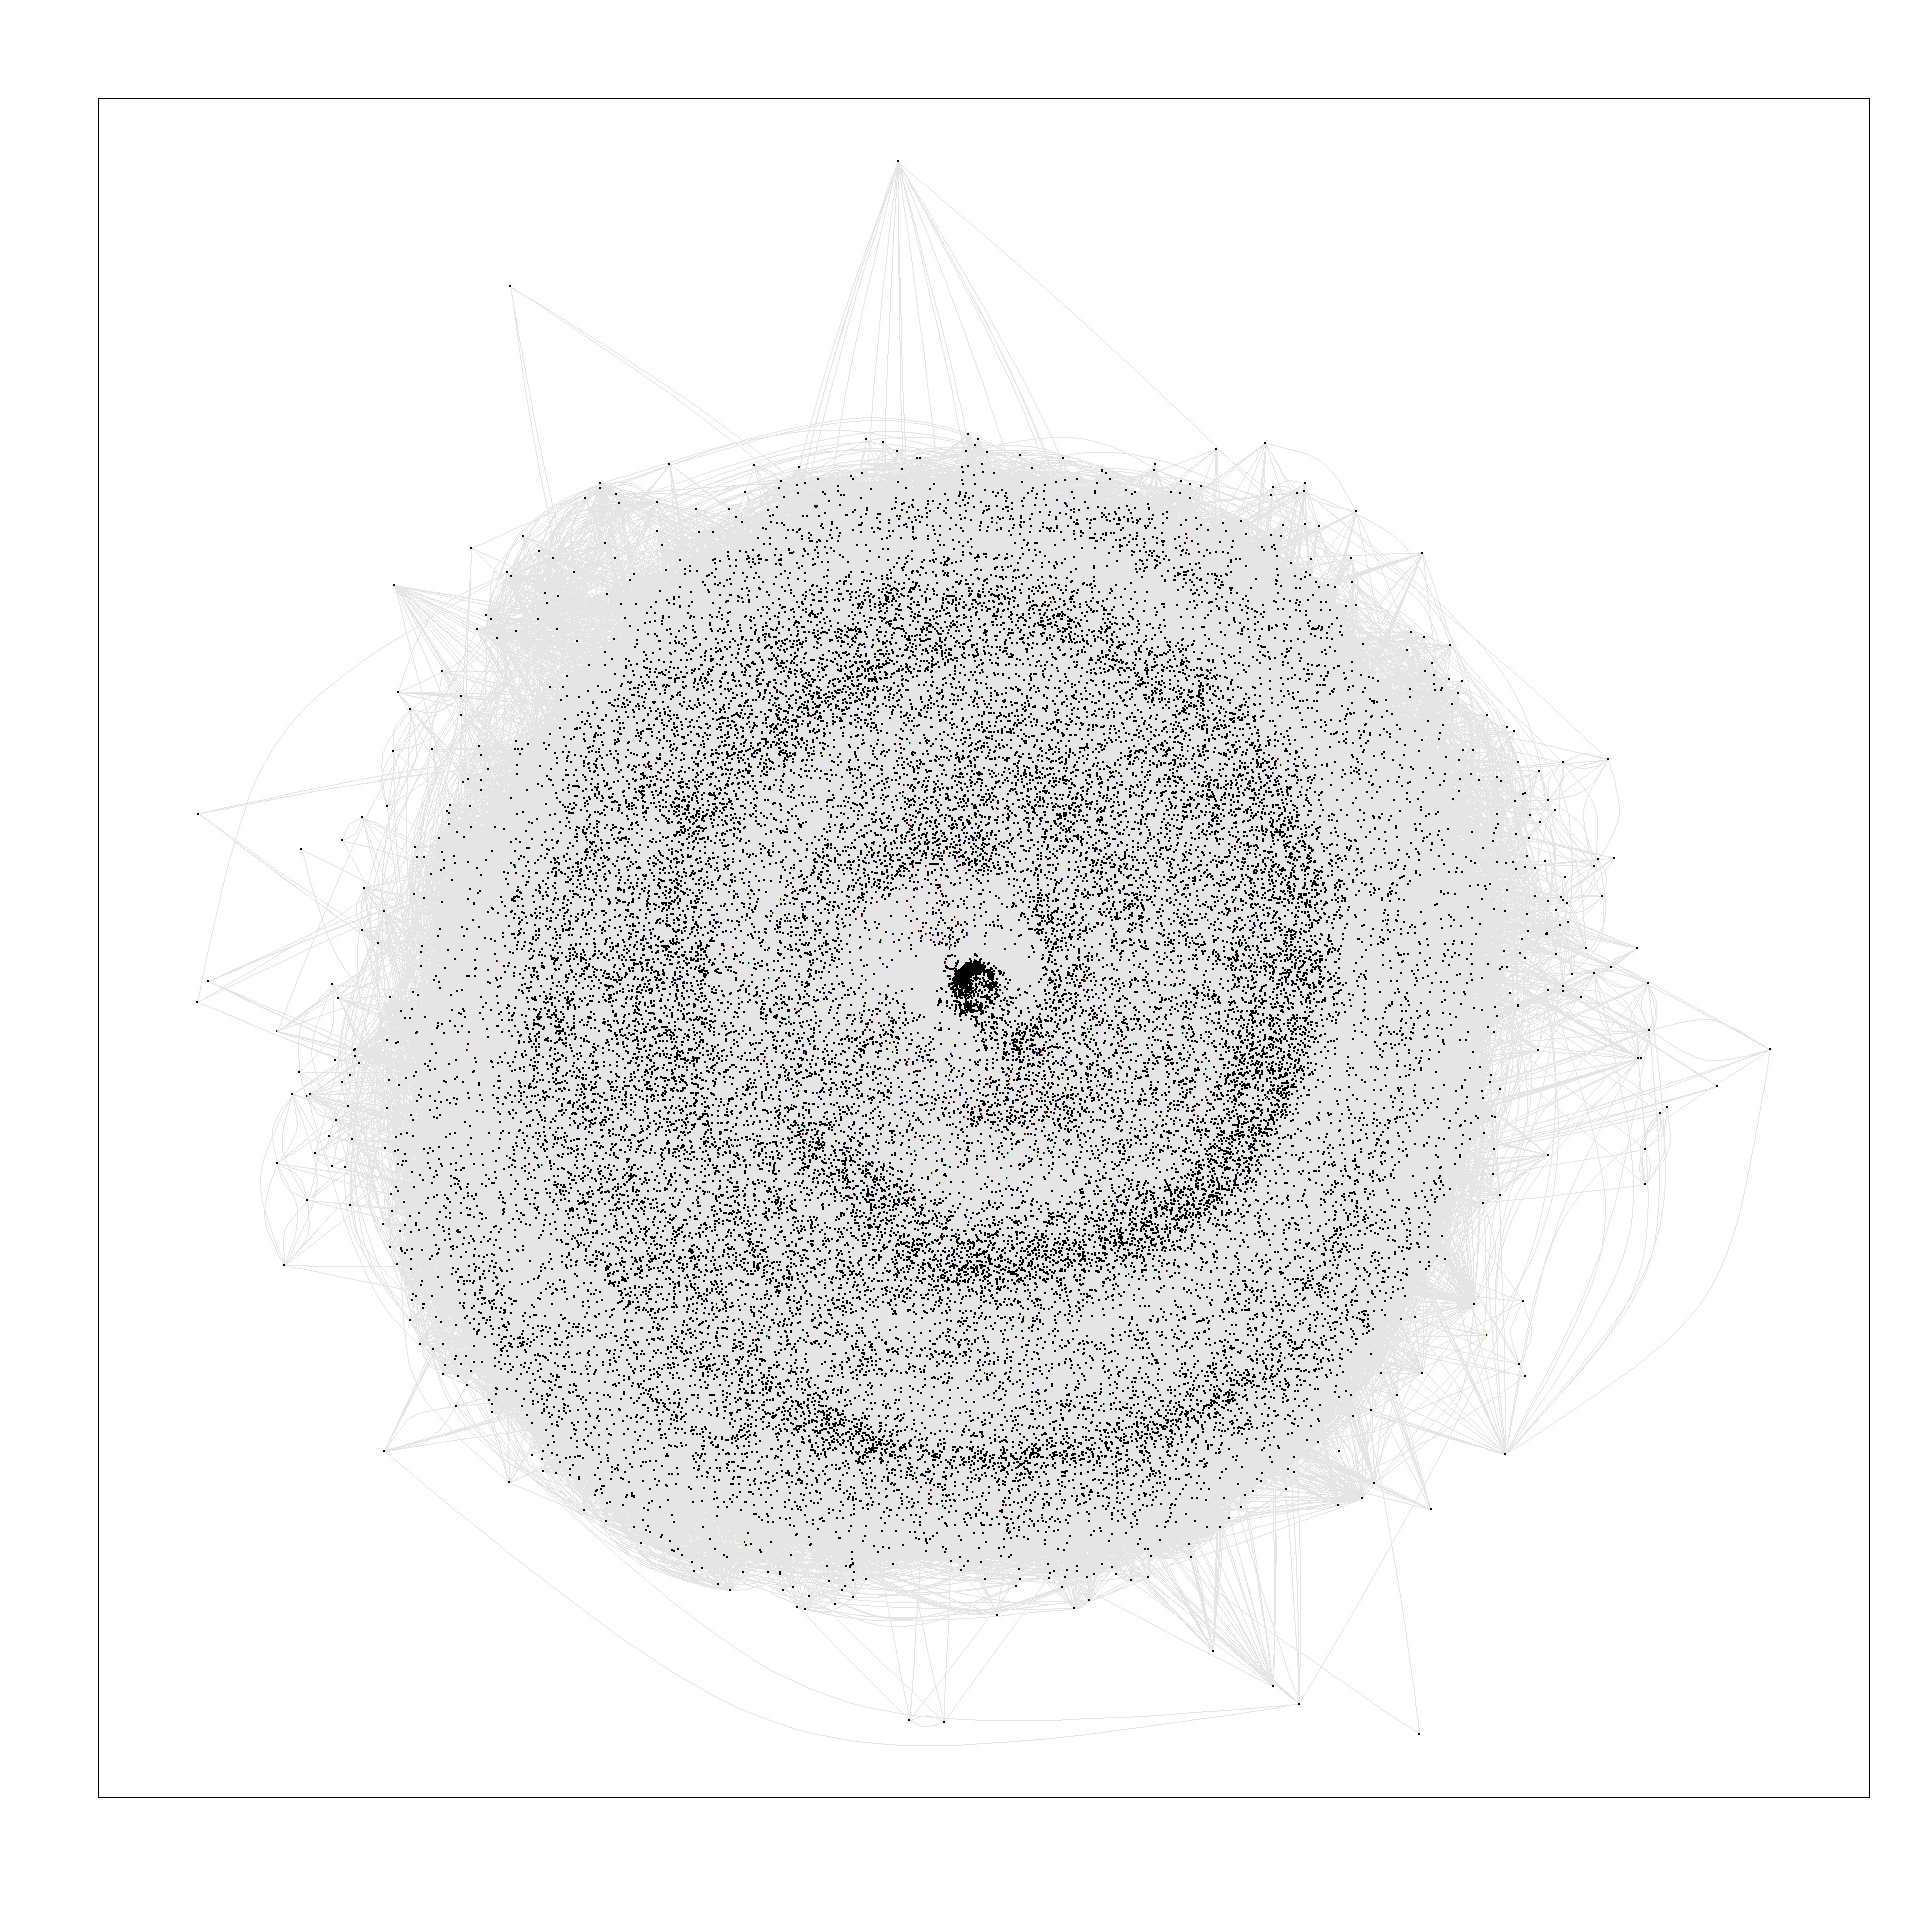

In [41]:
########
## Kamada Kawai Force Direct Graph Layout
########
options(repr.plot.width=16, repr.plot.height=16)

set.seed(54321) 

t0 <- Sys.time()

l_kk <- layout_with_kk(g_auth)

# pdf("D://CopyZ_30Nov2020//DFCM_Docs//DFCM_Researchers//PeterSelby//MineScopus_DFCM_National_International_PrimaryCareResearchPrograms//Output_NetworkAnalysis//IGraph_KK.pdf")

plot(g_auth, 
     layout=l_kk,  
     ## Vertex attributes
     #vertex.label = ifelse(degree(g_auth) > threshold, names(V(g_auth)), NA),
     vertex.label = NA,
     #vertex.label.cex=0.25,
     #vertex.label.color="red", 
     #vertex.label.font=2,
     vertex.shape="circle", 
     vertex.size=0.1, 
     vertex.color=V(g_auth)$color,
     vertex.frame.color='black',
     ## Edge attributes
     edge.mode=0,
     edge.color='grey90',
     edge.arrow.size=0.1, 
     edge.width=0.1,
     ## Other attributes
     frame=TRUE
     )

# dev.off()

t1 <- Sys.time()
# t1-t0

In [42]:
########
## Kamada Kawai Force Direct Graph Layout
########
# set.seed(54321) 

# t0 <- Sys.time()

# l_kk <- layout_with_kk(g_auth)

# pdf("D://CopyZ_30Nov2020//DFCM_Docs//DFCM_Researchers//PeterSelby//MineScopus_DFCM_National_International_PrimaryCareResearchPrograms//Output_NetworkAnalysis//IGraph_KK.pdf")

# plot(g_auth, 
#     layout=l_kk,  
#     ## Vertex attributes
#     #vertex.label = ifelse(degree(g_auth) > threshold, names(V(g_auth)), NA),
#     vertex.label = NA,
#     #vertex.label.cex=0.25,
#     #vertex.label.color="red", 
#     #vertex.label.font=2,
#     vertex.shape="circle", 
#     vertex.size=0.1, 
#     vertex.color="black",
#     vertex.frame.color='black',
#     ## Edge attributes
#     edge.mode=0,
#     edge.color='grey90',
#     edge.arrow.size=0.1, 
#     edge.width=0.1,
#     ## Other attributes
#     frame=TRUE
#     )

# dev.off()

# t1 <- Sys.time()
# t1-t0

In [43]:
###########################
## Session Information
###########################

In [44]:
Sys.Date()

[1] "2023-02-02"

In [45]:
sessionInfo()

R version 4.1.3 (2022-03-10)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17763)

Matrix products: default

locale:
[1] LC_COLLATE=English_United States.1252 
[2] LC_CTYPE=English_United States.1252   
[3] LC_MONETARY=English_United States.1252
[4] LC_NUMERIC=C                          
[5] LC_TIME=English_United States.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] igraph_1.3.1

loaded via a namespace (and not attached):
 [1] fansi_1.0.3     utf8_1.2.2      digest_0.6.29   crayon_1.5.1   
 [5] IRdisplay_1.1   repr_1.1.4      lifecycle_1.0.1 jsonlite_1.8.0 
 [9] magrittr_2.0.3  evaluate_0.15   pillar_1.7.0    rlang_1.0.2    
[13] cli_3.3.0       uuid_1.1-0      vctrs_0.4.1     ellipsis_0.3.2 
[17] IRkernel_1.3    tools_4.1.3     glue_1.6.2      fastmap_1.1.0  
[21] compiler_4.1.3  pkgconfig_2.0.3 base64enc_0.1-3 pbdZMQ_0.3-7   
[25] htmltools_0.5.2

In [46]:
version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          1.3                         
year           2022                        
month          03                          
day            10                          
svn rev        81868                       
language       R                           
version.string R version 4.1.3 (2022-03-10)
nickname       One Push-Up                 